In [19]:
import math
import pygame
import random
import numpy as np
from numpy import convolve
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [20]:
WIDTH = 800
HEIGHT = 600
maxScore = 1
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.init()
pygame.mixer.init()
font = pygame.font.Font(None, 30)
bigFont = pygame.font.Font(None, 72)
pygame.display.set_caption("Pong Game")
pygame.mouse.set_visible(0)
clock = pygame.time.Clock()

In [21]:
def plotRunningAverage(totalRewards):
    N = len(totalRewards)
    window = 100
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(totalRewards[max(0, t-window):(t+1)])
    plt.plot(running_avg)
    #plt.title()
    plt.show()
    
def movingaverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma    
    
    
class Pong_Env():
    
#     self.score1 = 0
#     self.score2 = 0
#     self.player1 = 0
#     self.player2 = 0
#     self.time = 0
    
    
    def __init__(self):
        self.time = 0
        self.L_paddle_xLoc = 50
        self.R_paddle_xLoc = WIDTH - 50
        self.LeftPaddle_center = np.array([self.L_paddle_xLoc, (HEIGHT/2)])
        self.RightPaddle_center = np.array([self.R_paddle_xLoc, (HEIGHT/2)])
        self.Paddle_thickness = 5
        self.Paddle_length = 45
        self.paddle_ymin = 50
        self.paddle_ymax = (HEIGHT - 50)
        
        # [    0,         1,          2,          3    ]
        # [left side, right side, top side, bottom side]
        self.LeftPaddle_area = np.array([(self.LeftPaddle_center[0] - self.Paddle_thickness), (self.LeftPaddle_center[0] + self.Paddle_thickness),
                              (self.LeftPaddle_center[1] - self.Paddle_length), (self.LeftPaddle_center[1] + self.Paddle_length)])
        self.RightPaddle_area = np.array([(self.RightPaddle_center[0] - self.Paddle_thickness), (self.RightPaddle_center[0] + self.Paddle_thickness),
                              (self.RightPaddle_center[1] - self.Paddle_length), (self.RightPaddle_center[1] + self.Paddle_length)])
        self.Paddle_vel = 5
        self.LeftPaddle_speed = 0
        self.RightPaddle_speed = 0
        self.Ball_center = np.array([(WIDTH/2), (HEIGHT/2)])
        self.Ball_radius = 5
        self.x_vel = 0
        self.y_vel = 0
        self.velocity = np.array([0.0, 0.0])
        self.Ball_speed = 8.0
        self.MaxSpeed = 25
        self.state = None
#        self.next_state = None
        self.steps_beyond_done = None
        self.R_action_space = ['up', 'still', 'down']
        self.L_action_space = ['up', 'down']
        self.L_state_space = ['left_paddle_y', 'ball_x', 'ball_y', 'ball_speed', 'ball_xvel', 'ball_yvel']
        self.R_state_space = ['right_paddle_y', 'ball_x', 'ball_y', 'ball_speed', 'ball_xvel', 'ball_yvel']
        self.L_reward = 0
        self.R_reward = 0
        self.L_bounce_tally = 0
        self.R_bounce_tally = 0
        self.L_score = 0
        self.R_score = 0
        self.done = False
        #self.reset()
    
    
    def OutOfBoundsMove(self, new_State_PadY):
        self.new_State_PadY = new_State_PadY
        if self.new_State_PadY < self.paddle_ymin or \
            self.new_State_PadY > self.paddle_ymax:
#            print('first')
            return True
        
#         elif self.new_state[1] < self.paddle_ymin or \
#             self.new_state[1] > self.paddle_ymax:
# #            print('second')
#             return True
        
        else:
#            print('second')
            return False
    
    
    def step(self, L_action, R_action):
#        if self.time >= 50:              # provides a short delay before the ball starts to move
   #     print('testStepState =', state)
   #     state = self.state
     #   next_state = self.next_state
        L_state = [self.LeftPaddle_center[1], self.Ball_center[0], self.Ball_center[1], \
            self.Ball_speed, self.velocity[0], self.velocity[1]]
        R_state = [self.RightPaddle_center[1], self.Ball_center[0], self.Ball_center[1], \
            self.Ball_speed, self.velocity[0], self.velocity[1]]
   #     print('stateStepBeginning=', state)
        LeftPaddle_startPos = self.LeftPaddle_center[1]
        RightPaddle_startPos = self.RightPaddle_center[1]
        if L_action == 0:
            self.LeftPaddle_speed = -1 * self.Paddle_vel # Move UP
#             elif L_action == 1:
#                 self.LeftPaddle_speed = 0 # Stay Still
        else: # L_action = 1
            self.LeftPaddle_speed = self.Paddle_vel # Move Down


        if R_action == 0:
            self.RightPaddle_speed = -1 * self.Paddle_vel # Move UP
        elif R_action == 1:
            self.RightPaddle_speed = 0 # Stay Still
        else: # R_action = 2
            self.RightPaddle_speed = self.Paddle_vel # Move Down


        #self.RightPaddle_KeyPress()  # Checks for if user wants to move right paddle with arrow keys
        
    #    print('before =', self.velocity)

        self.Ball_center += (self.Ball_speed * self.velocity) #* tau # Moves ball
        #print(self.Ball_center, self.LeftPaddle_center[1], self.RightPaddle_center[1])


        self.LeftPaddle_center[1] += (self.LeftPaddle_speed) #* tau # Moves left paddle
        self.LeftPaddle_area = np.array([(self.LeftPaddle_center[0] - self.Paddle_thickness), (self.LeftPaddle_center[0] + self.Paddle_thickness),
                          (self.LeftPaddle_center[1] - self.Paddle_length), (self.LeftPaddle_center[1] + self.Paddle_length)])
            

        self.RightPaddle_center[1] += (self.RightPaddle_speed) #* tau # Moves right paddle
        self.RightPaddle_area = np.array([(self.RightPaddle_center[0] - self.Paddle_thickness), (self.RightPaddle_center[0] + self.Paddle_thickness),
                          (self.RightPaddle_center[1] - self.Paddle_length), (self.RightPaddle_center[1] + self.Paddle_length)])

        
        
        self.Paddle_Bounce() # test for paddle bounces
        self.TandB_Bounce() # test for top and bottom wall bounces
        self.SideWall_Bounce() # test for side wall bounces


        # Determines the new state
        next_L_state = self.LeftPaddle_center[1], self.Ball_center[0],\
                    self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1]
        next_R_state = self.RightPaddle_center[1], self.Ball_center[0],\
                    self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1]
   #     print('next_state =', next_state)
    
        LeftNoMove_next_state = LeftPaddle_startPos, self.Ball_center[0],\
                    self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1]
        
        RightNoMove_next_state = RightPaddle_startPos, self.Ball_center[0],\
                    self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1]
        
        
        Leftwallmove = self.OutOfBoundsMove(next_L_state[0])
        Rightwallmove = self.OutOfBoundsMove(next_R_state[0])
   #     print('NoMove_next_state =', NoMove_next_state)
   #     print()
   #     self.next_state = self.LeftPaddle_center[1], self.RightPaddle_center[1], self.Ball_center[0],\
   #                 self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1]
        self.done = self.Ball_center[0] < -5 or \
            self.Ball_center[0] > WIDTH + 5
        self.done = bool(self.done)
        
        if not self.done:
       #     print('in loop =', self.velocity)
             if self.Ball_center[0] >= (self.LeftPaddle_area[0] - self.Ball_radius) and \
                self.Ball_center[0] <= (self.LeftPaddle_area[1] + 2.5 * self.Ball_radius) and \
                self.Ball_center[1] >= (self.LeftPaddle_area[2] - 2 * self.Ball_radius) and \
                self.Ball_center[1] <= (self.LeftPaddle_area[3] + 2 * self.Ball_radius) and \
                self.velocity[0] <= 0 and \
                self.Ball_center[0] >= 50 and \
                self.Ball_center[1] >= 140 and \
                self.Ball_center[1] <= (HEIGHT - 140):   #Ball hits Left Paddle when it was heading towards Left goal
                    self.L_bounce_tally += 1
                 #   print('paddle_bounce')
                    self.L_reward = 50.0 #* self.L_bounce_tally
                 #   print('L_bounce')
                    self.R_reward = .1
                    #print('Lr =', L_reward)
                    #print('Rr =', R_reward)
                    #print('activate1')
                    #self.L_score += self.L_reward
                    #self.R_score += self.R_reward
                    self.time += 1
                    
                    if Leftwallmove == True:
    #                    print('me2')
                        self.LeftPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = LeftNoMove_next_state
                        next_L_state = LeftNoMove_next_state
                        self.L_reward = -2
                   
                        self.L_score += self.L_reward
                    else:
                        self.L_score += self.L_reward
                    
                  
                    if Rightwallmove == True:
    #                    print('me3')
                        self.RightPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = RightNoMove_next_state
                        next_R_state = RightNoMove_next_state

                        self.R_reward = -1

                        self.R_score += self.R_reward
                    else:
                        self.R_score += self.R_reward
                  
                    return next_L_state, next_R_state, self.L_reward, self.R_reward, self.done, {}
    
    
    
    #Ball hits Right Paddle when it was heading towards Right goal
    

             if self.Ball_center[0] >= (self.RightPaddle_area[0] - 3.0 * self.Ball_radius) and \
                 self.Ball_center[0] <= (self.RightPaddle_area[1] + self.Ball_radius) and \
                 self.Ball_center[1] >= (self.RightPaddle_area[2] - 2.5 * self.Ball_radius) and \
                 self.Ball_center[1] <= (self.RightPaddle_area[3] + 2.5 * self.Ball_radius) and \
                 self.velocity[0] >= 0 and \
                 self.Ball_center[0] <= (WIDTH - 50) and \
                 self.Ball_center[1] >= 140 and \
                 self.Ball_center[1] <= (HEIGHT - 140):
                    self.R_bounce_tally += 1
                    self.R_reward = 50.0 #* self.R_bounce_tally
                #    print('R_bounce')
                    self.L_reward = .1
                   # print('Lr =', L_reward)
                   # print('Rr =', R_reward)
                   # print('activate2')
                    self.L_score += self.L_reward
                    self.R_score += self.R_reward
                    self.time += 1
                    if Leftwallmove == True:
                       # print('me2')
                        self.LeftPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = LeftNoMove_next_state
                        next_L_state = LeftNoMove_next_state
                        self.L_reward = -2
                        self.L_score += self.L_reward
                    else:
                        self.L_score += self.L_reward
                        
                        
                    if Rightwallmove == True:
    #                    print('me3')
                        self.RightPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = RightNoMove_next_state
                        next_R_state = RightNoMove_next_state  
                        self.R_reward = -2
                        self.R_score += self.R_reward
                    else:
                        self.R_score += self.R_reward 
                  
                    return next_L_state, next_R_state, self.L_reward, self.R_reward, self.done, {}








#                 elif self.velocity[0] > 0 and \
#                     self.state[1] in range(160, (HEIGHT - 160))

#             elif self.Ball_center[0] >= 0 and \
#                 self.Ball_center[0] <= 50 and \
#                 self.Ball_center[1] >= 140 and \
#                 self.Ball_center[1] <= (HEIGHT - 140):
#                     self.L_reward = -1
#                     self.R_reward = 1
#                     self.L_score += self.L_reward
#                     self.R_score += self.R_reward
#                     self.time += 1
#                     if not self.OutOfBoundsMove(next_state):
#       #                  print('me5')
#                         return next_state, self.L_reward, self.R_reward, self.done, {}
#                     else:
#     #                    print('me6')
#                         self.LeftPaddle_center[1], self.RightPaddle_center[1], self.Ball_center[0],\
#                             self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = NoMove_next_state
#                         self.L_reward = -1
#                         self.R_reward = -1
#                         self.L_score += self.L_reward
#                         self.R_score += self.R_reward
#                         return NoMove_next_state, self.L_reward, self.R_reward, self.done, {}

#             elif self.Ball_center[0] >= (WIDTH - 50) and \
#                 self.Ball_center[0] <= WIDTH and \
#                 self.Ball_center[1] >= 140 and \
#                 self.Ball_center[1] <= (HEIGHT - 140):
#                     self.R_reward = -1
#                     self.L_reward = 1
#                     self.L_score += self.L_reward
#                     self.R_score += self.R_reward
#                     self.time += 1
#                     if not self.OutOfBoundsMove(next_state):
#       #                  print('me7')
#                         return next_state, self.L_reward, self.R_reward, self.done, {}
#                     else:
#      #                   print('me8')
#                         self.LeftPaddle_center[1], self.RightPaddle_center[1], self.Ball_center[0],\
#                             self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = NoMove_next_state
#                         self.L_reward = -1
#                         self.R_reward = -1
#                         self.L_score += self.L_reward
#                         self.R_score += self.R_reward
#                         return NoMove_next_state, self.L_reward, self.R_reward, self.done, {}
             else: # ball moving around
     #           if random.random() >= 0: 
                #self.L_reward = .1 #(.9 + 1.1 * math.cos(((self.LeftPaddle_center[1] + 300)/95.493)))
                #self.R_reward = .1 #(.9 + 1.1 * math.cos(((self.RightPaddle_center[1] + 300)/95.493)))
                #print('activate3')
                #self.L_score += self.L_reward
                #self.R_score += self.R_reward
                self.time += 1
                if self.velocity[0] <= 0: # ball moving left
                    self.R_reward = .1
                    if self.LeftPaddle_center[1] >= 140 and \
                            self.LeftPaddle_center[1] <= (HEIGHT - 140):
                                self.L_reward = .2   
                    else:
                        self.L_reward = -.1
                   
                           
                
                    if Leftwallmove == True:
    #                    print('me6')
                        self.LeftPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = LeftNoMove_next_state
                        next_L_state = LeftNoMove_next_state
                        self.L_reward = -2
                      
                        self.L_score += self.L_reward
                      
                
                    else:
                        self.L_score += self.L_reward
                    if Rightwallmove == True:
    #                    print('me7')
                        self.RightPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = RightNoMove_next_state
                        next_R_state = RightNoMove_next_state
                        self.R_reward = -2

                        self.R_score += self.R_reward

                    else:
                        self.R_score += self.R_reward

                    return next_L_state, next_R_state, self.L_reward, self.R_reward, self.done, {}
                    
                    
                else: # ball moving right
                    self.L_reward = .1
                    if self.RightPaddle_center[1] >= 140 and \
                            self.RightPaddle_center[1] <= (HEIGHT - 140):
                                self.L_reward = .1
                                self.R_reward = 0.5
                    else:
                        self.R_reward = -.1
                           
                
                    if Leftwallmove == True:
    #                    print('me6')
                        self.LeftPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = LeftNoMove_next_state
                        next_L_state = LeftNoMove_next_state
                        self.L_reward = -2
                    
                        self.L_score += self.L_reward
                     
                     
                    else:
                        self.L_score += self.L_reward
                    if Rightwallmove == True:
    #                    print('me7')
                        self.RightPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = RightNoMove_next_state
                        next_R_state = RightNoMove_next_state
                        self.R_reward = -2
                      
                        self.R_score += self.R_reward
                      
                    else:
                        self.R_score += self.R_reward

                    return next_L_state, next_R_state, self.L_reward, self.R_reward, self.done, {} 
                    
        else:#if round is done
            if self.steps_beyond_done is None:
                # Ball just entered a goal!
                self.steps_beyond_done = 0
                self.time += 1
                if self.Ball_center[0] < -5:
                    self.L_reward = -.1 * abs(self.LeftPaddle_center[1] - self.Ball_center[1])
                    #print(self.L_reward)
                    #self.R_reward = 1
                    self.R_reward = 10.0 * (1 - (abs(self.RightPaddle_center[1] - 300) / 245))
                    #print('activate4')
                    
                    if Leftwallmove == True:
            #          print('me6')
                        self.LeftPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = LeftNoMove_next_state
                        next_L_state = LeftNoMove_next_state
                        self.L_reward = -.1 * abs(self.LeftPaddle_center[1] - self.Ball_center[1])
                   
                        self.L_score += self.L_reward
                  
                    else:
                        self.L_score += self.L_reward
                        
                    if Rightwallmove == True:
                #        print('me7')
                        self.RightPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = RightNoMove_next_state
                        next_R_state = RightNoMove_next_state
                        self.R_reward = -2
                        self.R_score += self.R_reward
                    else:
                        self.R_score += self.R_reward
                        
                    return next_L_state, next_R_state, self.L_reward, self.R_reward, self.done, {} 
                
                elif self.Ball_center[0] > WIDTH + 5:
                    self.R_reward = -.1 * abs(self.RightPaddle_center[1] - self.Ball_center[1])
                    #print(self.L_reward)
                    #self.R_reward = 1
                    self.L_reward = 10.0 * (1 - (abs(self.LeftPaddle_center[1] - 300) / 245))
                    #print('activate4')
                    
                    if Leftwallmove == True:
            #          print('me6')
                        self.LeftPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = LeftNoMove_next_state
                        next_L_state = LeftNoMove_next_state
                        self.L_reward = -2
                   
                        self.L_score += self.L_reward
                   
                    else:
                        self.L_score += self.L_reward
                        
                    if Rightwallmove == True:
                #        print('me7')
                        self.RightPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = RightNoMove_next_state
                        next_R_state = RightNoMove_next_state
                        self.R_reward = -.1 * abs(self.RightPaddle_center[1] - self.Ball_center[1])
                        self.R_score += self.R_reward
                    else:
                        self.R_score += self.R_reward
                        
                    return next_L_state, next_R_state, self.L_reward, self.R_reward, self.done, {}
                else:
                    if self.steps_beyond_done == 0:
                        logger.warn("You are calling 'step()' even though this  environment has already returned 'done = True' -- any further steps are undefined behavior.")
                    self.steps_beyond_done += 1
                    self.L_reward = 0.0
                    self.R_reward = 0.0
                    self.time += 1
                    #print('activate6')
                    if Leftwallmove == True:
            #          print('me6')
                        self.LeftPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = LeftNoMove_next_state
                        next_L_state = LeftNoMove_next_state
                        self.L_reward = 0
                        self.L_score += self.L_reward
                    else:
                        self.L_score += self.L_reward
                        
                    if Rightwallmove == True:
                #        print('me7')
                        self.RightPaddle_center[1], self.Ball_center[0],\
                            self.Ball_center[1], self.Ball_speed, self.velocity[0], self.velocity[1] = RightNoMove_next_state
                        next_R_state = RightNoMove_next_state
                        self.R_reward = 0
                        self.R_score += self.R_reward
                    else:
                        self.R_score += self.R_reward
                        
                    return next_L_state, next_R_state, self.L_reward, self.R_reward, self.done, {}
    

    
    def reset(self):
        self.LeftPaddle_center = np.array([50, (HEIGHT/2)])
        self.RightPaddle_center = np.array([(WIDTH-50), (HEIGHT/2)])
        self.Ball_center = np.array([WIDTH / 2, HEIGHT / 2])
        self.Ball_speed = 8.0
        self.x_vel = random.uniform(-1, 1)
        self.y_vel = random.uniform(-1, 1)
        self.velocity = np.array([self.x_vel / math.sqrt((self.x_vel ** 2)+(self.y_vel ** 2)),
                                  self.y_vel / math.sqrt((self.x_vel ** 2)+(self.y_vel ** 2))])  # <== [VelX, VelY]
                                # Doing this gives the velocity vector with the speed being 1, or unified. 
        self.LeftPaddle_speed = 0
        self.RightPaddle_speed = 0
        self.L_state = self.LeftPaddle_center[1], self.Ball_center[0], self.Ball_center[1],\
                        self.Ball_speed, self.velocity[0], self.velocity[1]
        self.R_state = self.RightPaddle_center[1], self.Ball_center[0], self.Ball_center[1],\
                         self.Ball_speed, self.velocity[0], self.velocity[1]
        
        #self.time = 0
        self.L_bounce_tally = 0
        self.R_bounce_tally = 0
        self.L_score = 0
        self.R_score = 0
        self.steps_beyond_done = None
        return np.array(self.R_state)
        
    def Paddle_Bounce(self):
        if self.Ball_center[0] >= (self.LeftPaddle_area[0] - self.Ball_radius) and \
            self.Ball_center[0] <= (self.LeftPaddle_area[1] + 1.0 * self.Ball_radius) and \
            self.Ball_center[1] >= (self.LeftPaddle_area[2] - 2 * self.Ball_radius) and \
            self.Ball_center[1] <= (self.LeftPaddle_area[3] + 2 * self.Ball_radius):
                diff = self.LeftPaddle_center[1] - self.Ball_center[1]
                self.Ball_center[0] -= self.Ball_speed * self.velocity[0]
                self.velocity[0] = -1 * self.velocity[0]
                self.velocity[1] = -diff/45
                if self.Ball_speed < self.MaxSpeed:
                    self.Ball_speed += .2
              #      print(self.Ball_center, self.velocity[0])
                self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                  (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
                #print('Left Paddle Bounce at (x,y) = ', self.Ball_center)
        
        if self.Ball_center[0] >= (self.RightPaddle_area[0] - self.Ball_radius) and \
            self.Ball_center[0] <= (self.RightPaddle_area[1] + self.Ball_radius) and \
            self.Ball_center[1] >= (self.RightPaddle_area[2] - 2.0 * self.Ball_radius) and \
            self.Ball_center[1] <= (self.RightPaddle_area[3] + 2.0 * self.Ball_radius):
                diff = self.RightPaddle_center[1] - self.Ball_center[1]
                self.Ball_center[0] -= self.Ball_speed * self.velocity[0]
           #     print(self.Ball_center, self.velocity[0])
                self.velocity[0] = -1 * self.velocity[0]
                self.velocity[1] = -diff/45
                if self.Ball_speed < self.MaxSpeed:
                    self.Ball_speed += .2
                self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                  (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
                #print('Right Paddle Bounce at (x,y) = ', self.Ball_center)
        
        else:
            self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                  (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
            
    def TandB_Bounce(self):
        if self.Ball_center[1] <= self.Ball_radius: # Ball bounces on top
            self.velocity[0] = self.velocity[0] * (random.random() + 1)
            self.velocity[1] = -1.0 * self.velocity[1]
            self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                  (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
            self.Ball_center[1] = 5
            
        elif self.Ball_center[1] >= (HEIGHT - self.Ball_radius): #Ball bounces on bottom   
            self.velocity[0] = self.velocity[0] * (random.random() + 1)
            self.velocity[1] = -1.0 * self.velocity[1]
            self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                  (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
            self.Ball_center[1] = (HEIGHT - 5)
            
        else: # Not bouncing, so just returns the current velocity
            self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                  (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
            
    def SideWall_Bounce(self): 
        if self.Ball_center[0] <= self.Ball_radius and self.Ball_center[1] <= 160 + self.Ball_radius:
            self.velocity[0] = -1.0 * self.velocity[0]
            self.velocity[1] = self.velocity[1] * (random.random() + 1)
            self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
            self.Ball_center[0] = 5
        
        elif self.Ball_center[0] <= self.Ball_radius and self.Ball_center[1] >= (HEIGHT - 160 - self.Ball_radius):
            self.velocity[0] = -1.0 * self.velocity[0]
            self.velocity[1] = self.velocity[1] * (random.random() + 1)
            self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
            self.Ball_center[0] = 5
        
        elif self.Ball_center[0] >= (WIDTH - self.Ball_radius) and self.Ball_center[1] <= 160: # + self.Ball_radius:
            self.velocity[0] = -1.0 * self.velocity[0]
            self.velocity[1] = self.velocity[1] * (random.random() + 1)
            self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
            self.Ball_center[0] = WIDTH - 5
            
            
        elif self.Ball_center[0] >= (WIDTH - self.Ball_radius) and self.Ball_center[1] >= HEIGHT - 160: #- self.Ball_radius:
            self.velocity[0] = -1.0 * self.velocity[0]
            self.velocity[1] = self.velocity[1] * (random.random() + 1)
            self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                 (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
            self.Ball_center[0] = WIDTH - 5
            
            
#         elif self.Ball_center[0] >= (WIDTH - self.Ball_radius) and self.Ball_center[1] >= HEIGHT - 160 - self.Ball_radius:
#             self.velocity[0] = -1.0 * self.velocity[0]
#             self.velocity[1] = self.velocity[1] * (random.random() + 1)
#             self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
#                                 (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
#             self.Ball_center[0] = WIDTH - 5  
            
        else:
            self.velocity = np.array([(self.velocity[0] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2))),
                                (self.velocity[1] / math.sqrt((self.velocity[0] ** 2) + (self.velocity[1] ** 2)))])
            
#     def RightPaddle_KeyPress(self):
#         self.RightPaddle_speed = 0
#         keys = pygame.key.get_pressed()
#         if keys[pygame.K_UP]:
#             self.RightPaddle_speed = -1 * self.Paddle_vel
#         if keys[pygame.K_DOWN]:
#             self.RightPaddle_speed = self.Paddle_vel
#         self.RightPaddle_center += self.RightPaddle_speed
    
    def Render(self, L_state, R_state):
        class TandBWall(pygame.sprite.Sprite):
            def __init__(self, y_pos):
                super().__init__()
                self.width = WIDTH
                self.height = 5
                self.image = pygame.Surface([self.width, self.height])
                self.image.fill((255, 255, 0))
                self.rect = self.image.get_rect()
                self.screenheight = HEIGHT
                self.screenwidth = WIDTH
                self.rect.centerx = WIDTH / 2
                self.rect.y = y_pos
        
        class sideWall(pygame.sprite.Sprite):
            def __init__(self, x_pos, height, y_pos):
                super().__init__()
                self.width = 5
                self.height = height
                self.image = pygame.Surface([self.width, self.height])
                self.image.fill((255, 255, 0))
                self.rect = self.image.get_rect()
                self.screenheight = HEIGHT
                self.screenwidth = WIDTH
                self.rect.centery = y_pos
                self.rect.x = x_pos
        
        class ball(pygame.sprite.Sprite):
            # ball constructor
            def __init__(self, x, y, speed, xvel, yvel):
                super().__init__()
                self.image = pygame.Surface([10, 10])
                pygame.draw.circle(self.image, (255, 255, 255), (5,5), 5)
                self.rect = self.image.get_rect()
                self.screenheight = HEIGHT
                self.screenwidth = WIDTH
                self.speed = speed
                self.x_pos = x
                self.y_pos = y
                self.x_vel = xvel
                self.y_vel = yvel
                self.maxSpeed = 25
                self.velocity = np.array([xvel, yvel])
                self.width = 10
                self.height = 10
            
                self.rect.center = np.array([x, y])
        
        class paddle(pygame.sprite.Sprite):
            # paddle constructor
            def __init__(self, x_pos, y_pos, vel):
                super().__init__()
                self.width = 10
                self.height = 90
                self.image = pygame.Surface([self.width, self.height])
                self.image.fill((255, 0, 0))
                self.speed = 0
                #self.up = upKey
                #self.down = downKey
                self.vel = vel
                self.rect = self.image.get_rect()
                self.screenheight = HEIGHT
                self.screenwidth = WIDTH

                self.rect.centery = y_pos
                self.rect.centerx = x_pos
        
        all_sprites = pygame.sprite.Group()
        TandBWalls = pygame.sprite.Group()
        balls = pygame.sprite.Group()
        sideWalls = pygame.sprite.Group()
        
        TopWall = TandBWall(-1)                                          # make top wall
        TandBWalls.add(TopWall)
        
        BottomWall = TandBWall(HEIGHT-4)                                 # make bottom wall
        TandBWalls.add(BottomWall)
        
        
       
        ball1 = ball(R_state[1], R_state[2], R_state[3], R_state[4], R_state[5])      # make ball
        all_sprites.add(ball1)
        balls.add(ball1)
        
        paddle1 = paddle(50, L_state[0], 5)                  # make left paddle
        all_sprites.add(paddle1)
        
        paddle2 = paddle((WIDTH-50), R_state[0], 5)      # make right paddle
        all_sprites.add(paddle2)
        
        TleftWall = sideWall(-1, 160, 80)                                # make top left wall
        sideWalls.add(TleftWall)

        TrightWall = sideWall(WIDTH-4, 160, 80)                          # make top right wall was WIDTH-4, 160, 80
        sideWalls.add(TrightWall)

        BleftWall = sideWall(-1, 160, HEIGHT-80)                         # make bottom left wall
        sideWalls.add(BleftWall)

        BrightWall = sideWall(WIDTH-4, 160, HEIGHT-80)                   # make bottom right wall was WIDTH-4, 160, HEIGHT-80
        sideWalls.add(BrightWall)
        
        screen.fill((0, 0, 0))
        all_sprites.draw(screen)
        TandBWalls.draw(screen)
        sideWalls.draw(screen)
        pygame.display.flip()
        time.sleep(.02)    

# Make DQN Agent for L_paddle

In [22]:
class DQNLAgent():
    def __init__(self, state_size, action_size, epsilon):
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen = 2000) #List of max length 2000 that I can add or remove data points to
        
        self.gamma = 0.95 # How much to discount future reward
        
        self.epsilon = epsilon # Explore primarily first
        self.epsilon_decay = 0.999 # After time, start to exploit more
        self.epsilon_min = 0.05 # Min ratio of eploration / exploitation is 5%
        
        self.learning_rate = 0.001 # Stocastic gradient decent step size
        
        self.zeta = .125 # impacts the training_model, .125 was original
        
        self.model = self._build_model()    # Builds the model for the prediction agent
        self.target_model = self._build_model()    #Builds the counter_intuitive model for tracking "target values".
        
    def _build_model(self):
        model = Sequential()
        
        model.add(Dense(36, input_dim = self.state_size, activation = 'relu', kernel_initializer=tf.contrib.layers.xavier_initializer()))
        model.add(Dense(96, activation = 'relu', kernel_initializer=tf.contrib.layers.xavier_initializer()))
#         model.add(Dense(96, activation = 'relu', kernel_initializer=tf.contrib.layers.xavier_initializer())) # L_model doesnt have this
    #    model.add(Dense(96, activation = 'relu',kernel_initializer=tf.contrib.layers.xavier_initializer()))
        model.add(Dense(48, activation = 'relu'))
        model.add(Dense(24, activation = 'relu',kernel_initializer=tf.contrib.layers.xavier_initializer()))
        model.add(Dense(self.action_size, activation = 'linear', kernel_initializer=tf.contrib.layers.xavier_initializer()))
    #    model.add(Dense(self.action_size, activation = 'sigmoid', kernel_initializer=tf.contrib.layers.xavier_initializer()))
        
    #    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = self.learning_rate)) # might change mse to 'categorical_crossentropy'  'mse'
        model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))
        #print(model)
        return model
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # Chooses a random action to perform (0 or 1)  
        act_values = self.model.predict(state) # Gets the action values by running the current state through the current model
#        print('act_values =', act_values)
        return np.argmax(act_values[0]) # returns the action with the highest act value
      
    def replay(self, batch_size):
        samples = random.sample(self.memory, batch_size) # Randomly samples from the memory 32 data points
        #print(len(agent.memory))
        #print(agent.memory)
   #     for state, action, reward, next_state, done in samples:
            
        for sample in samples:
            state, action, reward, next_state, done = sample
#             if reward > 0 and \
#                 reward <= 3:
#                 print('reward used in training between 0 and 3 =', reward)
#             if reward > 3:
#                 print('reward used in training above 3 =', reward)
#             if reward < 0:
       #     print('reward used in training =', reward)
#             if sample[2] != 1.0:
#                 print('reward =', sample[2])
            #if sample[2] == 0:
            #    print(sample[0])
            target = self.target_model.predict(state)
     #       print('target based on state =', target)
     #       print(state[0][0])
     #       print('action performed =', action)
     #       print(next_state[0][0])
            #print(target)
            if done:
                target[0][action] = reward
                #print('was done, target[0][action]', target[0][action])
                #print('done reward =', reward)
                #print('end of sample, should run fit')
            #target_f = self.model.predict(state)
            #x = next_state
            #print(type(x))
            #print(x)
            #print(self.model.predict(x))
            else:
                #print('was not done')
                #if not reward in range(0, 2):
                
     #           print('current reward =', reward)
             #   print('action = ', action)
     #           print('target_model_predict based on next state =',self.target_model.predict(next_state)[0])
                Q_future = max(self.target_model.predict(next_state)[0])
     #           print('Q_future, should be max of predict on next state =', Q_future)
                target[0][action] = reward + (Q_future * self.gamma)
     #           print('target[0][action], should be reward + Q_f*gamma =', target[0][action])
     #           print('target, should have changed 1 value of target =', target)
                #print('end of sample, should run fit')
                #print('was not done, target =', target)
                #target = (reward + self.gamma * np.amax(self.model.predict(next_state)))
                #print('target =', target)
            #target_f = self.model.predict(state) #taget_f is 'future reward'
            #print('target_f =', target_f)
            #target_f[0][action] = target
            #print('performed learning')
            self.model.fit(state, target, epochs = 1, verbose = 0)
     #       print('ran fit')
            
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        #print('weights =', weights)
        #print('target_weights =', target_weights)
#         for i in range(len(target_weights)):
#             target_weights[i] = weights[i] * self.zeta + target_weights[i] * (1 - self.zeta)
#         self.target_model.set_weights(target_weights)
        target_weights = weights
        self.target_model.set_weights(target_weights)
        #print('performed target_train')
    
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self, name):
        self.model.save_weights(name)

# Make DQN Agent for R_Paddle

In [23]:
class DQNRAgent():
    def __init__(self, state_size, action_size, epsilon):
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen = 2000) #List of max length 2000 that I can add or remove data points to
        
        self.gamma = 0.95 # How much to discount future reward
        
        self.epsilon = epsilon # Explore primarily first
        self.epsilon_decay = 0.999 # After time, start to exploit more
        self.epsilon_min = 0.05 # Min ratio of eploration / exploitation is 5%
        
        self.learning_rate = 0.001 # Stocastic gradient decent step size
        
        self.zeta = .125 # impacts the training_model, .125 was original
        
        self.model = self._build_model()    # Builds the model for the prediction agent
        self.target_model = self._build_model() # model does the actual predictions on what action to take, and
                                                   # the target model tracks what action we want our model to take
        
    def _build_model(self):
        model = Sequential()
        
        model.add(Dense(36, input_dim = self.state_size, activation = 'relu', kernel_initializer=tf.contrib.layers.xavier_initializer()))
        model.add(Dense(96, activation = 'relu', kernel_initializer=tf.contrib.layers.xavier_initializer()))
        model.add(Dense(96, activation = 'relu', kernel_initializer=tf.contrib.layers.xavier_initializer())) # L_model doesnt have this
    #    model.add(Dense(96, activation = 'relu',kernel_initializer=tf.contrib.layers.xavier_initializer()))
        model.add(Dense(48, activation = 'relu'))
        model.add(Dense(24, activation = 'relu',kernel_initializer=tf.contrib.layers.xavier_initializer()))
        model.add(Dense(self.action_size, activation = 'linear', kernel_initializer=tf.contrib.layers.xavier_initializer()))
    #    model.add(Dense(self.action_size, activation = 'sigmoid', kernel_initializer=tf.contrib.layers.xavier_initializer()))
        
    #    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = self.learning_rate)) # might change mse to 'categorical_crossentropy'  'mse'
        model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))
        #print(model)
        return model
     
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # Chooses a random action to perform (0 or 1)  
        act_values = self.model.predict(state) # Gets the action values by running the current state through the current model
#        print('act_values =', act_values)
        return np.argmax(act_values[0]) # returns the action with the highest act value
      
    def replay(self, batch_size):
        samples = random.sample(self.memory, batch_size) # Randomly samples from the memory 32 data points
        #print(len(agent.memory))
        #print(agent.memory)
   #     for state, action, reward, next_state, done in samples:
            
        for sample in samples:
            state, action, reward, next_state, done = sample
#             if reward > 0 and \
#                 reward <= 3:
#                 print('reward used in training between 0 and 3 =', reward)
#             if reward > 3:
#                 print('reward used in training above 3 =', reward)
#             if reward < 0:
       #     print('reward used in training =', reward)
#             if sample[2] != 1.0:
#                 print('reward =', sample[2])
            #if sample[2] == 0:
            #    print(sample[0])
            target = self.target_model.predict(state)
     #       print('target based on state =', target)
     #       print(state[0][0])
     #       print('action performed =', action)
     #       print(next_state[0][0])
            #print(target)
            if done:
                target[0][action] = reward
                #print('was done, target[0][action]', target[0][action])
                #print('done reward =', reward)
                #print('end of sample, should run fit')
            #target_f = self.model.predict(state)
            #x = next_state
            #print(type(x))
            #print(x)
            #print(self.model.predict(x))
            else:
                #print('was not done')
                #if not reward in range(0, 2):
                
     #           print('current reward =', reward)
             #   print('action = ', action)
     #           print('target_model_predict based on next state =',self.target_model.predict(next_state)[0])
                Q_future = max(self.target_model.predict(next_state)[0])
     #           print('Q_future, should be max of predict on next state =', Q_future)
                target[0][action] = reward + (Q_future * self.gamma)
     #           print('target[0][action], should be reward + Q_f*gamma =', target[0][action])
     #           print('target, should have changed 1 value of target =', target)
                #print('end of sample, should run fit')
                #print('was not done, target =', target)
                #target = (reward + self.gamma * np.amax(self.model.predict(next_state)))
                #print('target =', target)
            #target_f = self.model.predict(state) #taget_f is 'future reward'
            #print('target_f =', target_f)
            #target_f[0][action] = target
            #print('performed learning')
            self.model.fit(state, target, epochs = 1, verbose = 0)
     #       print('ran fit')
            
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        #print('weights =', weights)
        #print('target_weights =', target_weights)
#         for i in range(len(target_weights)):
#             target_weights[i] = weights[i] * self.zeta + target_weights[i] * (1 - self.zeta)
#         self.target_model.set_weights(target_weights)
        target_weights = weights
        self.target_model.set_weights(target_weights)
        #print('performed target_train')
    
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self, name):
        self.model.save_weights(name)

# Learning

episode: 0/500, time: 257, L_score: 88.14489795918308, R_score: 69.62822960776585, eL: 0.05, eR: 0.05
episode: 1/500, time: 355, L_score: 102.74489795918323, R_score: 25.67365864456069, eL: 0.05, eR: 0.05
episode: 2/500, time: 84, L_score: 7.819675854483824, R_score: 15.95102040816325, eL: 0.05, eR: 0.05
episode: 3/500, time: 469, L_score: 65.4285714285719, R_score: 295.1545004312725, eL: 0.05, eR: 0.05
episode: 4/500, time: 1673, L_score: 294.9489795918333, R_score: 1134.9491737417404, eL: 0.05, eR: 0.05
episode: 5/500, time: 364, L_score: 144.95237362360595, R_score: 87.32244897959114, eL: 0.05, eR: 0.05
episode: 6/500, time: 339, L_score: 100.14489795918325, R_score: 103.0953154530576, eL: 0.05, eR: 0.05
episode: 7/500, time: 253, L_score: 64.5903732416457, R_score: 358.5306122449015, eL: 0.05, eR: 0.05
episode: 8/500, time: 265, L_score: 88.93673469387696, R_score: 266.1009810888077, eL: 0.05, eR: 0.05
episode: 9/500, time: 148, L_score: 15.208163265306087, R_score: 57.548833124716

episode: 79/500, time: 819, L_score: 209.136734693873, R_score: 233.38038155694306, eL: 0.05, eR: 0.05
episode: 80/500, time: 660, L_score: 86.52448979591752, R_score: 262.1611766114406, eL: 0.05, eR: 0.05
episode: 81/500, time: 550, L_score: 96.5312385518856, R_score: 68.73469387755145, eL: 0.05, eR: 0.05
episode: 82/500, time: 1074, L_score: 197.54897959183543, R_score: 226.91373018504717, eL: 0.05, eR: 0.05
episode: 83/500, time: 989, L_score: 230.66122448979212, R_score: 295.8690269967507, eL: 0.05, eR: 0.05
episode: 84/500, time: 468, L_score: 116.14081632653044, R_score: 333.2427396657019, eL: 0.05, eR: 0.05
episode: 85/500, time: 739, L_score: 108.86938775510185, R_score: 255.5905276609004, eL: 0.05, eR: 0.05
episode: 86/500, time: 482, L_score: 113.26938775510175, R_score: 202.09809439473472, eL: 0.05, eR: 0.05
episode: 87/500, time: 655, L_score: 186.57755102040647, R_score: 303.1888996415846, eL: 0.05, eR: 0.05
episode: 88/500, time: 366, L_score: 51.65202073659667, R_score: 

episode: 158/500, time: 607, L_score: 235.80408163264977, R_score: 354.97807392422106, eL: 0.05, eR: 0.05
episode: 159/500, time: 1501, L_score: 203.05306122448897, R_score: 535.0104418265229, eL: 0.05, eR: 0.05
episode: 160/500, time: 385, L_score: 143.1014461688056, R_score: 176.0306122448974, eL: 0.05, eR: 0.05
episode: 161/500, time: 50, L_score: 5.408163265306121, R_score: 16.160342232785254, eL: 0.05, eR: 0.05
episode: 162/500, time: 824, L_score: 169.33265306122243, R_score: 362.50909775590327, eL: 0.05, eR: 0.05
episode: 163/500, time: 229, L_score: 27.33993183548123, R_score: 31.267346938775567, eL: 0.05, eR: 0.05
episode: 164/500, time: 885, L_score: 20.040816326530376, R_score: 420.70489384516884, eL: 0.05, eR: 0.05
episode: 165/500, time: 773, L_score: 248.68947739043534, R_score: 511.06326530612415, eL: 0.05, eR: 0.05
episode: 166/500, time: 342, L_score: 43.116326530612554, R_score: 92.1827649260161, eL: 0.05, eR: 0.05
episode: 167/500, time: 657, L_score: 138.72040816326

episode: 237/500, time: 1031, L_score: 131.36122448979603, R_score: 519.3699364760247, eL: 0.05, eR: 0.05
episode: 238/500, time: 455, L_score: 116.16122448979505, R_score: 136.24072337652217, eL: 0.05, eR: 0.05
episode: 239/500, time: 671, L_score: 97.64489795918377, R_score: 142.588653393814, eL: 0.05, eR: 0.05
episode: 240/500, time: 878, L_score: 374.58979591836726, R_score: 299.48846547306226, eL: 0.05, eR: 0.05
episode: 241/500, time: 50, L_score: 5.816326530612243, R_score: 17.002374704880605, eL: 0.05, eR: 0.05
episode: 242/500, time: 690, L_score: 190.24081632652724, R_score: 168.29847139662823, eL: 0.05, eR: 0.05
episode: 243/500, time: 1731, L_score: 111.61051546548171, R_score: 543.5224489795992, eL: 0.05, eR: 0.05
episode: 244/500, time: 237, L_score: 31.161224489795988, R_score: 146.34315185102412, eL: 0.05, eR: 0.05
episode: 245/500, time: 292, L_score: 36.95714285714297, R_score: 61.21950616353513, eL: 0.05, eR: 0.05
episode: 246/500, time: 384, L_score: 31.753061224489

episode: 315/500, time: 800, L_score: 99.25356012542811, R_score: 492.9510204081671, eL: 0.05, eR: 0.05
episode: 316/500, time: 82, L_score: 7.9059723014872265, R_score: 15.955102040816314, eL: 0.05, eR: 0.05
episode: 317/500, time: 1457, L_score: 164.36485548955162, R_score: 516.8306122449086, eL: 0.05, eR: 0.05
episode: 318/500, time: 792, L_score: 42.54897959183705, R_score: 280.88494831874596, eL: 0.05, eR: 0.05
episode: 319/500, time: 2554, L_score: 480.53265306123023, R_score: 690.218771884032, eL: 0.05, eR: 0.05
episode: 320/500, time: 1230, L_score: 333.15714285714364, R_score: 562.1920926139474, eL: 0.05, eR: 0.05
episode: 321/500, time: 811, L_score: 147.34081632653084, R_score: 143.70668719126846, eL: 0.05, eR: 0.05
episode: 322/500, time: 839, L_score: 213.5448979591798, R_score: 273.8591783639131, eL: 0.05, eR: 0.05
episode: 323/500, time: 344, L_score: 45.44897959183683, R_score: 46.26681587281038, eL: 0.05, eR: 0.05
episode: 324/500, time: 364, L_score: 149.4795661806215

episode: 394/500, time: 383, L_score: 151.92857142857082, R_score: 95.52782152796719, eL: 0.05, eR: 0.05
episode: 395/500, time: 399, L_score: 100.38406998635604, R_score: 101.85102040816284, eL: 0.05, eR: 0.05
episode: 396/500, time: 771, L_score: 244.14489795917976, R_score: 179.8190488280783, eL: 0.05, eR: 0.05
episode: 397/500, time: 161, L_score: 14.320408163265276, R_score: 54.32891158729882, eL: 0.05, eR: 0.05
episode: 398/500, time: 809, L_score: 262.90255774904097, R_score: 384.03061224490295, eL: 0.05, eR: 0.05
episode: 399/500, time: 1591, L_score: 331.76122448979504, R_score: 571.8202195625638, eL: 0.05, eR: 0.05
episode: 400/500, time: 656, L_score: -158.23877551020752, R_score: 87.60234009335854, eL: 0.05, eR: 0.05
episode: 401/500, time: 441, L_score: 108.27088074503946, R_score: 189.93469387754993, eL: 0.05, eR: 0.05
episode: 402/500, time: 1758, L_score: 347.032653061227, R_score: 641.337457406152, eL: 0.05, eR: 0.05
episode: 403/500, time: 50, L_score: 6.2244897959183

episode: 473/500, time: 430, L_score: 112.86530612244866, R_score: 91.63211622573674, eL: 0.05, eR: 0.05
episode: 474/500, time: 1357, L_score: 266.348979591835, R_score: 844.770026135248, eL: 0.05, eR: 0.05
episode: 475/500, time: 359, L_score: 96.32610149799905, R_score: 105.27142857142812, eL: 0.05, eR: 0.05
episode: 476/500, time: 1615, L_score: 485.66938775510454, R_score: 819.2064636743434, eL: 0.05, eR: 0.05
episode: 477/500, time: 377, L_score: 53.53673469387786, R_score: 248.86661742602473, eL: 0.05, eR: 0.05
episode: 478/500, time: 217, L_score: 28.544897959183796, R_score: 39.04062721390271, eL: 0.05, eR: 0.05
episode: 479/500, time: 995, L_score: 187.844897959182, R_score: 304.02966679273254, eL: 0.05, eR: 0.05
episode: 480/500, time: 50, L_score: 5.408163265306121, R_score: 16.388981759554593, eL: 0.05, eR: 0.05
episode: 481/500, time: 827, L_score: 163.46122448979304, R_score: 279.32057939805355, eL: 0.05, eR: 0.05
episode: 482/500, time: 51, L_score: 6.120408163265304, R

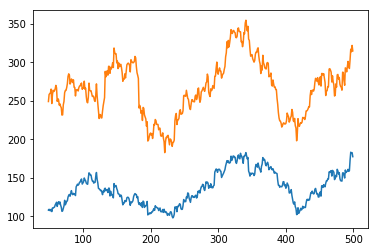

In [24]:
env = Pong_Env()
# state = [paddle_y, ball_x, ball_y, ball_speed, ball_xvel, ball_yvel]
# state = [left_paddle_y, right_paddle_y, ball_x, ball_y, ball_speed, ball_xvel, ball_yvel]
L_state_size = len(env.L_state_space)
R_state_size = len(env.R_state_space)
#print('state_size =', state_size)
# action = [up, still, down]
L_action_size = len(env.L_action_space)
R_action_size = len(env.R_action_space)
#print('action_size =', action_size)
batch_size = 32 # Used for gradient descent
n_episodes = 500 # Number of games played
L_totalRewards = np.zeros(n_episodes)
R_totalRewards = np.zeros(n_episodes)
#rand_num = 0

output_dir = 'model_output/pongSinglePaddleTraining'
# output_dir = 'model_output/pongTraining'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
L_agent = DQNLAgent(L_state_size, L_action_size, 0.05)

L_agent.load('model_output\pongSinglePaddleTrainingweightsL6_0100.hdf5')
# L_agent.load('model_output\pongSinglePaddleTrainingweightsL4_1500.hdf5')
#L_agent.load('model_output\pongSinglePaddleTrainingweightsL1_1000.hdf5')
#L_agent.load('model_output\pongtrainingweightsL8_7000.hdf5')
R_agent = DQNRAgent(R_state_size, R_action_size, 0.05)
#R_agent.load('model_output\pongSinglePaddleTrainingweightsR5_1000.hdf5')
R_agent.load('model_output\pongSinglePaddleTrainingweightsR4_4000.hdf5')
# R_agent.load('model_output\pongSinglePaddleTrainingweightsR1_2000.hdf5')
#done = False
for e in range(n_episodes):
 #   print('e=', e)
    L_state = env.reset()
    L_state = np.reshape(L_state, (1, L_state_size))
    R_state = env.reset()
    R_state = np.reshape(R_state, (1, R_state_size))
#    L_agent.memory = []
#    R_agent.memory = []
    #state = state[0]
    done = False
    for t in range(10000):
       # if e > 0:
           # env.Render(L_state[0], R_state[0])
 #           tau = .2
  #      print(t) 
 #       print('state_BeforeEpisode=', state)
  #      print('nextState_Before=', next_state)
        L_action = L_agent.act(L_state)
      #  print('L_action = ', L_action, L_reward)
        R_action = R_agent.act(R_state)
 #       print('R_action = ', R_action)
        next_L_state, next_R_state, L_reward, R_reward, done, _ = env.step(L_action, R_action)
#         next_L_state, L_reward, done, _ = env.step(L_action)
#         next_R_state, R_reward, done, _ = env.step(R_action)
  #      print('stateAfter =', state)
  #      print('nextStateAfterStep =', next_state)
     #   print('done =', done)
     #   print('R_reward=', R_reward)
     #   print([L_reward, R_reward, next_state[5]])
     #   print(L_state[0])
        #rounded_data = [round(elem,2) for elem in data]
        #print(rounded_data)


#         mystate = [round(x,2) for x in state]
#         data = [mystate, reward, t, done]
#         print(data)

        next_L_state = np.reshape(next_L_state, [1, L_state_size])
        next_R_state = np.reshape(next_R_state, [1, R_state_size])
        
        #if L_reward == -1 or L_reward == 0.1:
        if L_reward == -1 or L_reward == 0.2 or L_reward == -.1 or L_reward == .1:    
            if np.random.rand() <= .1:
                L_agent.remember(L_state, L_action, L_reward, next_L_state, done)
        else:
            L_agent.remember(L_state, L_action, L_reward, next_L_state, done)
        
        
        if R_reward == -2 or R_reward == 0.5 or R_reward == -.1 or R_reward == .1:    
            if np.random.rand() <= .2:
                R_agent.remember(R_state, R_action, R_reward, next_R_state, done)
        else:
            R_agent.remember(R_state, R_action, R_reward, next_R_state, done)
        
        
   #     print(len(L_agent.memory))    
            
#         if R_reward == -1 or R_reward == 0.1:
#             if np.random.rand() <= .1:
#                 R_agent.remember(state, R_action, R_reward, next_state, done)
#         else:
#             R_agent.remember(state, R_action, R_reward, next_state, done)    
   #     print(len(R_agent.memory))
 


 #       print('state[0][5] =', state[0][5])
        #rand_num = random.randint(1,1001)
  #      print('rand_num =', rand_num)
  #      if state[0][5] < 0 and \
#         if state[0][2] < (WIDTH - 100) and \
#             L_reward >= 0 and \
#             L_reward <= 2.5 and \
#             random.random() > 0.99:
                #print('L_r between 0 and 2 =', L_reward)
  #      if L_reward != 0.1:
  #              L_agent.remember(state, L_action, L_reward, next_state, done)
                #print('activate1, >75 and == 1', rand_num, L_reward)
#         if state[0][5] < 0 and \
#             L_reward != 1.0 and \
#             L_reward != 0:
#                 L_agent.remember(state, L_action, L_reward, next_state, done)

#         if state[0][2] < (WIDTH - 100) and \
#             L_reward < 0 or \
#             L_reward > 2.5:
#                 #print('rand_num =', rand_num)
#                 #print('L_r outside 0 and 2 =', L_reward)
#                 L_agent.remember(state, L_action, L_reward, next_state, done)

                #print('activate2')

      #  if state[0][5] > 0 and \
#         if state[0][2] > 100 and \
#             R_reward >= 0 and \
#             R_reward <= 2.5 and \
#             random.random() > 0.99:
  #      if R_reward != 0.1:
  #              R_agent.remember(state, R_action, R_reward, next_state, done)
                #print('activate3,  >75 and == 1', rand_num, R_reward)    
#         if state[0][5] > 0 and \
#             R_reward != 1.0 and \
#             R_reward != 0:
#                 R_agent.remember(state, R_action, R_reward, next_state, done)

#         if state[0][2] < 100 and \
#             R_reward < 0 or \
#             R_reward > 2.5:
#                 #print('rand_num =', rand_num)
#                 #print('L_r outside 0 and 2 =', L_reward)
#                 R_agent.remember(state, R_action, R_reward, next_state, done)
                #print('activate4')
        #print('memory =', len(L_agent.memory))
        #if rand_num > 99:
            #print('L_agent.memory =', L_agent.memory[0][2])
            #print('shape of L_memory =', len(L_agent.memory))
#         if rand_num < 1:
#             print('R_agent.memory =', R_agent.memory[0])

#        print('next_stateEnd =', next_state)
        L_state = next_L_state
        
        R_state = next_R_state
#        print('stateEnd after set to next_state =', state)

    #    time.sleep(.01)
#         if t % 150 == 0:
#             if len(L_agent.memory) > batch_size:
#                 L_agent.replay(batch_size)
#                 L_agent.target_train()
#                 #print('replay1')

#             if len(R_agent.memory) > batch_size:
#                 R_agent.replay(batch_size)
#                 R_agent.target_train()
#                 #print('replay2')
    
        if done:
            #print(env.L_bounce_tally, env.R_bounce_tally)
            print("episode: {}/{}, time: {}, L_score: {}, R_score: {}, eL: {:.2}, eR: {:.2}".format(e, n_episodes, t, env.L_score, env.R_score, L_agent.epsilon, R_agent.epsilon))
#            print("episode: {}/{}, time: {}, L_score: {}, LBounce_num: {}, eL: {:.2}".format(e, n_episodes, t, env.L_score, env.L_bounce_tally, L_agent.epsilon))
          #  print("episode: {}/{}, time: {}, R_score: {}, RBounce_num: {}, eR: {:.2}".format(e, n_episodes, t, env.R_score, env.R_bounce_tally, R_agent.epsilon))
            break

    L_totalRewards[e] = env.L_score
    R_totalRewards[e] = env.R_score
                
#     if len(L_agent.memory) > batch_size:
#         L_agent.replay(batch_size)
#         L_agent.target_train()
        #print('replay1')

#     if len(R_agent.memory) > batch_size:
#         R_agent.replay(batch_size)
#         if e % 2 == 0:
#             R_agent.target_train()
           # print('replay2')

#     if e % 1000 == 0:
#       #  L_agent.save(output_dir +  "weightsL6_" + '{:04d}'.format(e) + ".hdf5")
#         R_agent.save(output_dir +  "weightsR7_" + '{:04d}'.format(e) + ".hdf5")
        
#plotRunningAverage(L_totalRewards)

#plotRunningAverage(R_totalRewards)

x = np.zeros(n_episodes)
for i in range(0, n_episodes):
    x[i] = i
    
y = L_totalRewards
yMA = movingaverage(L_totalRewards, 50)

z = R_totalRewards
zMA = movingaverage(R_totalRewards, 50)
# print(yMA)

#plt.plot(x, y)

plt.plot(x[len(x)-len(yMA):], yMA)
plt.plot(x[len(x)-len(zMA):], zMA)
plt.show()
# plt.plot(R_totalRewards)
# plt.show()